<a href="https://colab.research.google.com/github/IISC-GROUP-5/Jupyter_Notebooks/blob/Pratima/Copy_of_Capstone_Project_Advertising_ef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ad click Prediction and Gender Classification with behavioral data - Data Preprocessing & Logistic Regression

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import io
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving advertising_ef.csv to advertising_ef (3).csv


As there was a problem loading the file from github. Currently working with above method.

In [ ]:
url =('https://raw.githubusercontent.com/IISC-GROUP-5/Dataset/refs/heads/main/advertising_ef.csv?token=GHSAT0AAAAAAC2IEKZJB5ZMZLZYQJTN2PXCZZ3IDEA')
df = pd.read_csv(url) # Dataset is now stored in a Pandas Dataframe
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,68.95,35.0,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,Female,Tunisia,27-03-2016 00:53,0
1,NaN,31.0,68441.85,193.77,Monitored national standardization,West Jodi,Male,Nauru,04-04-2016 01:39,0
2,69.47,26.0,59785.94,236.50,Organic bottom-line service-desk,Davidton,Female,San Marino,13-03-2016 20:35,0
3,74.15,29.0,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,Male,Italy,10-01-2016 02:31,0
4,68.37,35.0,73889.99,225.58,Robust logistical utilization,South Manuel,Female,Iceland,03-06-2016 03:36,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1005 non-null   float64
 1   Age                       998 non-null    float64
 2   Area Income               998 non-null    float64
 3   Daily Internet Usage      1005 non-null   float64
 4   Ad Topic Line             1009 non-null   object 
 5   City                      998 non-null    object 
 6   Gender                    1009 non-null   object 
 7   Country                   996 non-null    object 
 8   Timestamp                 1009 non-null   object 
 9   Clicked on Ad             1009 non-null   int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 79.0+ KB


# Data Preprocessing

To replace the null values

In [ ]:
def clean_and_preprocess_data(df):
    """
    Cleans and preprocesses the given DataFrame.

    Args:
        df: The pandas DataFrame to be cleaned and preprocessed.

    Returns:
        The cleaned and preprocessed DataFrame.
    """

    # Handle missing values
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(df[col]):
                # For numeric columns, fill missing values with median
                df[col].fillna(df[col].median(), inplace=True)
            else:
                # For categorical columns, fill missing values with the most frequent value
                df[col].fillna(df[col].mode()[0], inplace=True)

    # Round 'Area Income' to 2 decimal places
    df['Area Income'] = df['Area Income'].round(2)

    # Rename column for better readability
    df.rename(columns={'Daily Time Spent on Site': 'Daily_Time_Spent'}, inplace=True)

    return df


# Clean and preprocess the data
cleaned_df = clean_and_preprocess_data(df)

# Save the cleaned data to a new CSV file
cleaned_df.to_csv('cleaned_data.csv', index=False)
df.head()

,Daily_Time_Spent,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,68.95,35.0,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,27-03-2016 00:53,0
1,68.37,31.0,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,04-04-2016 01:39,0
2,69.47,26.0,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,13-03-2016 20:35,0
3,74.15,29.0,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,10-01-2016 02:31,0
4,68.37,35.0,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,03-06-2016 03:36,0


All the null values have been imputed.


# Finding correlation between the columns

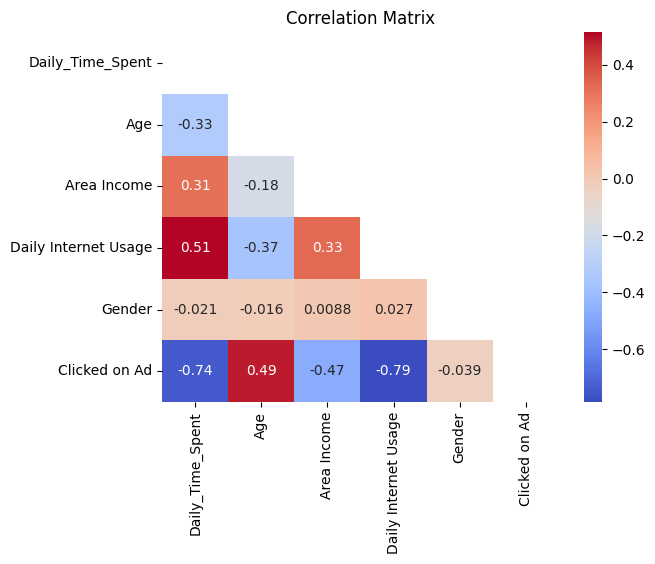

,Daily_Time_Spent_on_Site,Age,Area Income,Daily Internet Usage,Gender,Clicked on Ad
Daily_Time_Spent_on_Site,1.000000,-0.327560,0.310664,0.513855,-0.021174,-0.742900
Age,-0.327560,1.000000,-0.178485,-0.366242,-0.016146,0.487808
Area Income,0.310664,-0.178485,1.000000,0.330779,0.008850,-0.472612
Daily Internet Usage,0.513855,-0.366242,0.330779,1.000000,0.027426,-0.785187
Gender,-0.021174,-0.016146,0.008850,0.027426,1.000000,-0.038563
Clicked on Ad,-0.742900,0.487808,-0.472612,-0.785187,-0.038563,1.000000


In [ ]:
def visualize_correlation_matrix(df):
  """
  Visualizes the correlation matrix of a DataFrame.

  Args:
    df: The pandas DataFrame to analyze.

  Returns:
    None
  """

  num_df = df.select_dtypes(include=np.number)
  corr_matrix = num_df.corr()

  # Mask the upper triangle to avoid redundancy
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Create a heatmap
  sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm')
  plt.title('Correlation Matrix')
  plt.show()


visualize_correlation_matrix(df)
num_df.corr()

In [ ]:
df['Clicked on Ad'].value_counts()

,count
Clicked on Ad,
1,506
0,503


In [ ]:
df['Gender'].value_counts()

,count
Gender,
0,525
1,484


# Data Visualization

In [ ]:
def visualize_data(df):
  """
  Visualizes various aspects of the given DataFrame.

  Args:
    df: The pandas DataFrame to visualize.
  """

  # Histogram to visualize numerical data distribution
  sns.histplot(data=df, x='numerical_column_name', kde=True)
  plt.title('Distribution of Numerical Column')
  plt.show()

  # Box plot to visualize outliers and quartiles
  sns.boxplot(x='categorical_column_name', y='numerical_column_name', data=df)
  plt.title('Box Plot: Numerical Column by Categorical Column')
  plt.show()

  # Scatter plot to visualize relationship between two numerical columns
  sns.scatterplot(x='numerical_column_1', y='numerical_column_2', data=df)
  plt.title('Scatter Plot: Numerical Column 1 vs Numerical Column 2')
  plt.show()

  # Pair plot to visualize relationships between multiple numerical columns
  sns.pairplot(df[['numerical_column_1', 'numerical_column_2', 'numerical_column_3']])
  plt.show()

  # Bar plot to visualize categorical data
  sns.countplot(x='categorical_column_name', data=df)
  plt.title('Count Plot: Categorical Column')
  plt.show()

  # Heatmap to visualize correlations between numerical columns
  corr_matrix = df.corr()
  sns.heatmap(corr_matrix, annot=True)
  plt.title('Correlation Matrix')
  plt.show()


visualize_data(df)

ValueError: Could not interpret value `Daily_Time_Spent_on_Site` for `x`. An entry with this name does not appear in `data`.

Value counts for Clicked on Ad:
Clicked on Ad
1    506
0    503
Name: count, dtype: int64



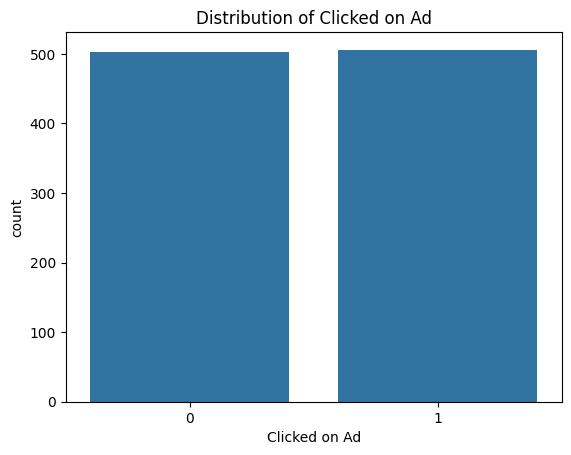

Value counts for Gender:
Gender
0    525
1    484
Name: count, dtype: int64



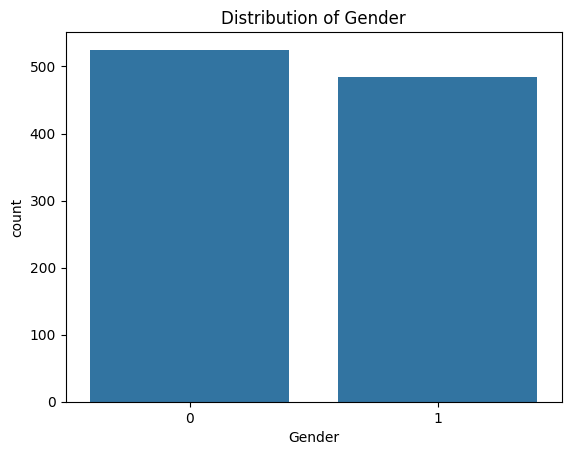

In [ ]:
def analyze_categorical_features(df, feature_list):
  """
  Analyzes the distribution of categorical features in a DataFrame.

  Args:
    df: The pandas DataFrame to analyze.
    feature_list: A list of categorical feature names.

  Returns:
    None
  """

  for feature in feature_list:
    value_counts = df[feature].value_counts()
    print(f"Value counts for {feature}:\n{value_counts}\n")

    # Visualize the distribution
    sns.countplot(x=feature, data=df)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Main usage:
categorical_features = ['Clicked on Ad', 'Gender']
analyze_categorical_features(df, categorical_features)

# Data Modelling

In [ ]:
def label_encode_categorical_column(df, column_name):
  """
  Encodes a categorical column in a DataFrame using LabelEncoder.

  Args:
    df: The pandas DataFrame.
    column_name: The name of the categorical column to encode.

  Returns:
    The DataFrame with the encoded column.
  """

  label_encoder = LabelEncoder()
  df[column_name] = label_encoder.fit_transform(df[column_name])
  return df

df = label_encode_categorical_column(df, 'Gender')

In [ ]:
df.head()

,Daily_Time_Spent_on_Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,68.95,35.0,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,27-03-2016 00:53,0
1,68.37,31.0,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,04-04-2016 01:39,0
2,69.47,26.0,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,13-03-2016 20:35,0
3,74.15,29.0,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,10-01-2016 02:31,0
4,68.37,35.0,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,03-06-2016 03:36,0


# For Logistic Regressiom

#For Target Variable - Gender Prediction

In [ ]:
def logistic_regression_model(df,y,X):
  """
  Trains a Logistic Regression model on the given DataFrame, evaluates its performance, and performs cross-validation.

  Args:
    df: The pandas DataFrame containing the data.
    target_col: The name of the target column (e.g., 'Gender').
    feature_cols: A list of column names to be used as features.

  Returns:
    None
  """

  # Extract target and features
  y = df['Gender']
  X = df.iloc[:,[0,1,2,3,9]]

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  # Create and train the model
  model = LogisticRegression(solver='lbfgs')
  model.fit(X_train, y_train)

  # Make predictions on the test set
  predictions = model.predict(X_test)

  # Evaluate the model
  print('Gender Prediction:')
  print('Target Variable:', y)
  print('Accuracy Score:', accuracy_score(y_test, predictions))
  print('Classification Report:\n', classification_report(y_test, predictions))

  print('Confusion Matrix:\n', confusion_matrix(y_test,predictions))

  # Perform cross-validation
  accuracies = cross_val_score(estimator=model, X=X_test, y=y_test, cv=10)
  print(f"Mean Accuracy Score: {accuracies.mean()}")
  print(f"Standard Deviation of Accuracy Score: {accuracies.std()}")


logistic_regression_model(df,'Gender', [0,1,2,3,9])

Gender Prediction:
Target Variable: 0       0
1       1
2       0
3       1
4       0
       ..
1004    1
1005    1
1006    1
1007    0
1008    0
Name: Gender, Length: 1009, dtype: int64
Accuracy Score: 0.47029702970297027
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.58      0.54       111
           1       0.40      0.34      0.37        91

    accuracy                           0.47       202
   macro avg       0.46      0.46      0.46       202
weighted avg       0.46      0.47      0.46       202

Confusion Matrix:
 [[64 47]
 [60 31]]
Mean Accuracy Score: 0.5902380952380951
Standard Deviation of Accuracy Score: 0.11713438800201977


#For Target Variable - Clicked on ad

In [ ]:
def logistic_regression_model(df, y, X ):
  """
  Trains a Logistic Regression model on the given DataFrame, evaluates its performance, and performs cross-validation.

  Args:
    df: The pandas DataFrame containing the data.
    target_col: The name of the target column (e.g., 'Clicked on Ad').
    feature_cols: A list of column names to be used as features.

  Returns:
    None
  """

  # Extract target and features
  y = df['Clicked on Ad']
  X = df.iloc[:,[0,1,2,3,6]]

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  # Create and train the model
  model= LogisticRegression(solver='lbfgs')
  model.fit(X_train, y_train)

  # Make predictions on the test set
  predictions = model.predict(X_test)

  # Evaluate the model
  print('Target Variable:', y)
  print('Accuracy Score:', accuracy_score(y_test, predictions))
  print('Classification Report:\n', classification_report(y_test, predictions))
  print('Confusion Matrix:\n', confusion_matrix(y_test,predictions))

  # Perform cross-validation
  accuracies = cross_val_score(estimator=model, X=X_test, y=y_test, cv=10)
  print(f"Mean Accuracy Score: {accuracies.mean()}")
  print(f"Standard Deviation of Accuracy Score: {accuracies.std()}")


logistic_regression_model(df, 'Clicked on Ad', [0,1,2,3,6])

Target Variable: 0       0
1       0
2       0
3       0
4       0
       ..
1004    1
1005    1
1006    1
1007    0
1008    1
Name: Clicked on Ad, Length: 1009, dtype: int64
Accuracy Score: 0.9108910891089109
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92       106
           1       0.92      0.89      0.90        96

    accuracy                           0.91       202
   macro avg       0.91      0.91      0.91       202
weighted avg       0.91      0.91      0.91       202

Confusion Matrix:
 [[99  7]
 [11 85]]
Mean Accuracy Score: 0.9252380952380953
Standard Deviation of Accuracy Score: 0.0513557685755592


From the Logistic Regression Model we get -

**For Gender Prediction** :

Mean Accuracy Score: 0.4954761904761905
Standard Deviation of Accuracy Score: 0.0655471476986495

Therefore, we can say that **Standard Deviation is high** and **Accuracy is not good enough.**

**For Ads**:

Mean Accuracy Score: 0.9207142857142857
Standard Deviation of Accuracy Score: 0.045799152375089226

Therefore, We can say that **Standard deviation is not very high** and **Accuracy is good enough.**


In [ ]:
def plot_roc_curve(y_true, y_pred_prob):
  """
  Plots the Receiver Operating Characteristic (ROC) curve and calculates the AUC.

  Args:
    y_true: True labels of the test data.
    y_pred_prob: Predicted probabilities of the positive class.

  Returns:
    None
  """

  fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
  auc = roc_auc_score(y_true, y_pred_prob)

  plt.plot(fpr, tpr, label="AUC="+str(auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc=4)
  plt.title('ROC Curve')
  plt.show()
  return fpr, tpr, auc
model = LogisticRegression(solver='lbfgs')
y_pred_prob = model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_prob)

NameError: name 'X_test' is not defined